## Usecase : to determine whether a person makes over 50K per year.

# 1. Importing required libraries

In [1]:
!pip install category_encoders
!pip install pymongo
import numpy as np
import pandas as pd
import pymongo 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import RobustScaler

# loading data into database and retrieving

In [2]:
data=pd.read_csv('Dataset_Usecase-s_final-.csv')
#converting dataframe to dictonary
data_dict= data.to_dict(orient="records")
#create a database in mongodb
client = pymongo.MongoClient("mongodb://localhost:27017")
data1 = client["Usecase5"]
print(data1)
data1.file1.insert_many(data_dict)
#Retrieve the data from mongodb
data1.file1.find();
mydb = client['Usecase5']
print(mydb.list_collection_names()) 
#check the records
allrecords = mydb['file1'].find()
list_courser = list(allrecords)
df = pd.DataFrame(list_courser)

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'Usecase5')
['file1']


# 2. Analyzing data set

In [3]:
df.head()

,_id,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,6257e7b4f2ab9de03622b044,0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,6257e7b4f2ab9de03622b045,1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,6257e7b4f2ab9de03622b046,2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,6257e7b4f2ab9de03622b047,3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,6257e7b4f2ab9de03622b048,4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
df.drop(df.columns[[0,1,6]], axis= 1, inplace= True)

In [5]:
df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65122 entries, 0 to 65121
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              65122 non-null  int64 
 1    workclass       61450 non-null  object
 2    fnlwgt          65122 non-null  int64 
 3    education       65122 non-null  object
 4    marital-status  65122 non-null  object
 5    occupation      61436 non-null  object
 6    relationship    65122 non-null  object
 7    race            65122 non-null  object
 8    sex             65122 non-null  object
 9    capital-gain    65122 non-null  int64 
 10   capital-loss    65122 non-null  int64 
 11   hours-per-week  65122 non-null  int64 
 12   native-country  63956 non-null  object
 13   income          65122 non-null  object
dtypes: int64(5), object(9)
memory usage: 7.0+ MB


In [7]:
df.columns

Index(['age', ' workclass', ' fnlwgt', ' education', ' marital-status',
       ' occupation', ' relationship', ' race', ' sex', ' capital-gain',
       ' capital-loss', ' hours-per-week', ' native-country', ' income'],
      dtype='object')

### The names of the columns are not proper (having spaces, '-' etc)
#### Setting up the names

In [8]:
edited_cols = ['age', 'workclass', 'fnlwgt', 'education', 'marital_status', 'occupation', 'relationship',
             'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
df.columns = edited_cols

df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'marital_status',
       'occupation', 'relationship', 'race', 'sex', 'capital_gain',
       'capital_loss', 'hours_per_week', 'native_country', 'income'],
      dtype='object')

## Categorical Columns

In [9]:
cat_columns=[col for col in df.columns if df[col].dtype=='object']

In [10]:
cat_columns

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country',
 'income']

In [11]:
for val in cat_columns:
    print('Columns Name: ----------------------------------%s'%val)
    print(df[val].value_counts())

Columns Name: ----------------------------------workclass
 Private             45392
 Self-emp-not-inc     5082
 Local-gov            4186
 State-gov            2596
 Self-emp-inc         2232
 Federal-gov          1920
 Without-pay            28
 Never-worked           14
Name: workclass, dtype: int64
Columns Name: ----------------------------------education
 HS-grad         21002
 Some-college    14582
 Bachelors       10710
 Masters          3446
 Assoc-voc        2764
 11th             2350
 Assoc-acdm       2134
 10th             1866
 7th-8th          1292
 Prof-school      1152
 9th              1028
 12th              866
 Doctorate         826
 5th-6th           666
 1st-4th           336
 Preschool         102
Name: education, dtype: int64
Columns Name: ----------------------------------marital_status
 Married-civ-spouse       29952
 Never-married            21366
 Divorced                  8886
 Separated                 2050
 Widowed                   1986
 Married-spouse-a

## Numerical Columns

In [12]:
num_columns=[col for col in df.columns if df[col].dtype=='int64']

In [13]:
num_columns

['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week']

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,65122.0,38.581647,13.640328,17.0,28.0,37.0,48.0,90.0
fnlwgt,65122.0,189778.366512,105549.167280,12285.0,117827.0,178356.0,237051.0,1484705.0
capital_gain,65122.0,1077.648844,7385.235380,0.0,0.0,0.0,0.0,99999.0
capital_loss,65122.0,87.303830,402.957125,0.0,0.0,0.0,0.0,4356.0
hours_per_week,65122.0,40.437456,12.347334,1.0,40.0,40.0,45.0,99.0


## Target Column

In [15]:
df['income'].value_counts()

 <=50K    49440
 >50K     15682
Name: income, dtype: int64

In [16]:
df['income'].value_counts()/len(df)

 <=50K    0.75919
 >50K     0.24081
Name: income, dtype: float64

# 3. Exploratory data analysis

In [17]:
df.isnull().sum()

age                  0
workclass         3672
fnlwgt               0
education            0
marital_status       0
occupation        3686
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country    1166
income               0
dtype: int64

In [18]:
for x in [df]:
    x['workclass'].fillna(df['workclass'].mode()[0], inplace=True)
    x['occupation'].fillna(df['occupation'].mode()[0], inplace=True)
    x['native_country'].fillna(df['native_country'].mode()[0], inplace=True)

In [19]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

### Categorical Columns

#### work_class

In [20]:
df['workclass'].value_counts()

 Private             49064
 Self-emp-not-inc     5082
 Local-gov            4186
 State-gov            2596
 Self-emp-inc         2232
 Federal-gov          1920
 Without-pay            28
 Never-worked           14
Name: workclass, dtype: int64

Text(0.5, 1.0, 'Frequency Distribution of WorkClass')

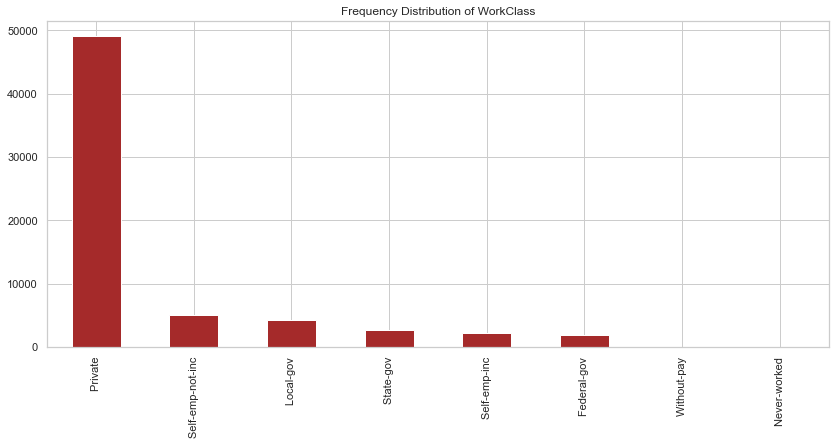

In [21]:
plt.figure(figsize=(14,6))
ax=df['workclass'].value_counts().plot(kind='bar',color='brown')
ax.set_title('Frequency Distribution of WorkClass')

##### More Private workers compared to anyother

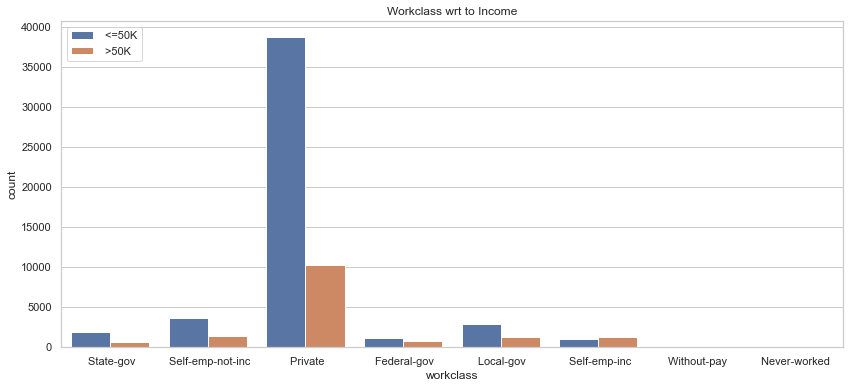

In [22]:
plt.figure(figsize=(14,6))
ax=sns.countplot(x='workclass',hue='income',data=df)
ax.set_title('Workclass wrt to Income')
ax.legend()

#### Most of the people are earning <=50k

#### occupation

In [23]:
df['occupation'].value_counts()

 Prof-specialty       11966
 Craft-repair          8198
 Exec-managerial       8132
 Adm-clerical          7540
 Sales                 7300
 Other-service         6590
 Machine-op-inspct     4004
 Transport-moving      3194
 Handlers-cleaners     2740
 Farming-fishing       1988
 Tech-support          1856
 Protective-serv       1298
 Priv-house-serv        298
 Armed-Forces            18
Name: occupation, dtype: int64

Text(0.5, 1.0, 'Frequency Distribution of Occupation')

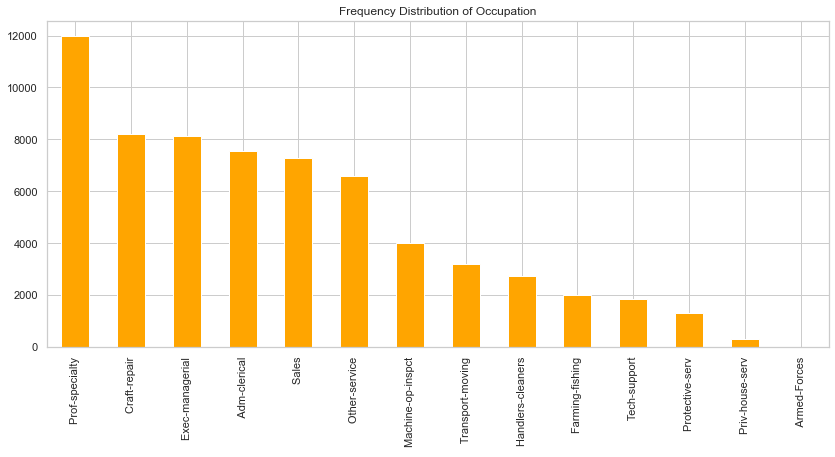

In [24]:
plt.figure(figsize=(14,6))
ax=df['occupation'].value_counts().plot(kind='bar',color='orange')
ax.set_title('Frequency Distribution of Occupation')

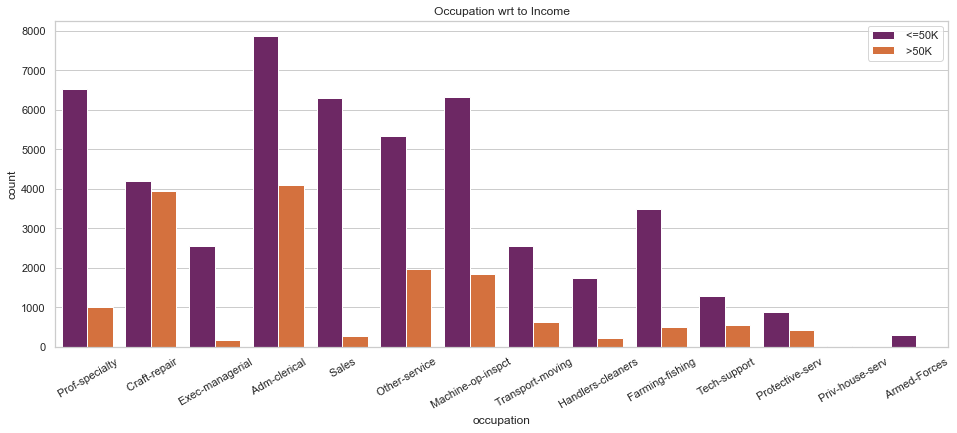

In [25]:
plt.figure(figsize=(16,6))
ax=sns.countplot(x='occupation',hue='income',data=df,palette='inferno')
ax.set_title('Occupation wrt to Income')
ax.set_xticklabels(df.occupation.value_counts().index, rotation=30)
ax.legend()

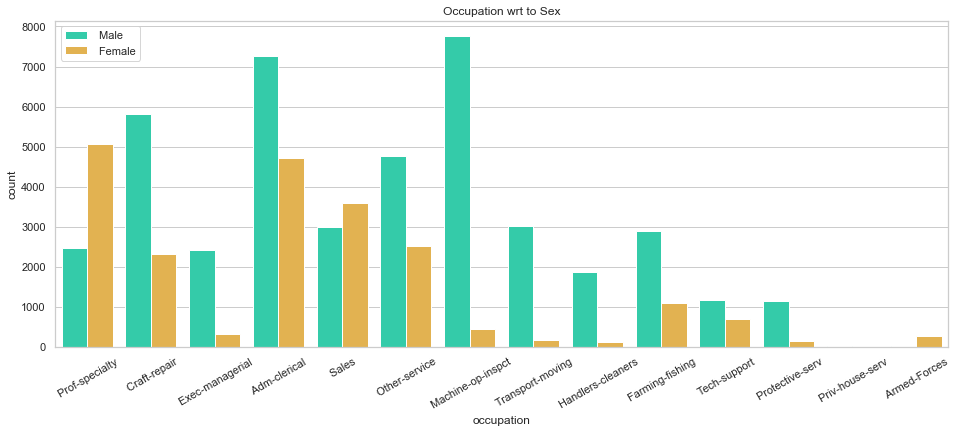

In [26]:
plt.figure(figsize=(16,6))
ax=sns.countplot(x='occupation',hue='sex',data=df,palette='turbo')
ax.set_title('Occupation wrt to Sex')
ax.set_xticklabels(df.occupation.value_counts().index, rotation=30)
ax.legend()

#### Most of the occuaptions are dominated by Males
##### Sales and Prof-speciality are the regions where females are more

#### martial_status

In [27]:
df['marital_status'].value_counts()

 Married-civ-spouse       29952
 Never-married            21366
 Divorced                  8886
 Separated                 2050
 Widowed                   1986
 Married-spouse-absent      836
 Married-AF-spouse           46
Name: marital_status, dtype: int64

#### relationship

In [28]:
df['relationship'].value_counts()

 Husband           26386
 Not-in-family     16610
 Own-child         10136
 Unmarried          6892
 Wife               3136
 Other-relative     1962
Name: relationship, dtype: int64

#### race

In [29]:
df['race'].value_counts()

 White                 55632
 Black                  6248
 Asian-Pac-Islander     2078
 Amer-Indian-Eskimo      622
 Other                   542
Name: race, dtype: int64

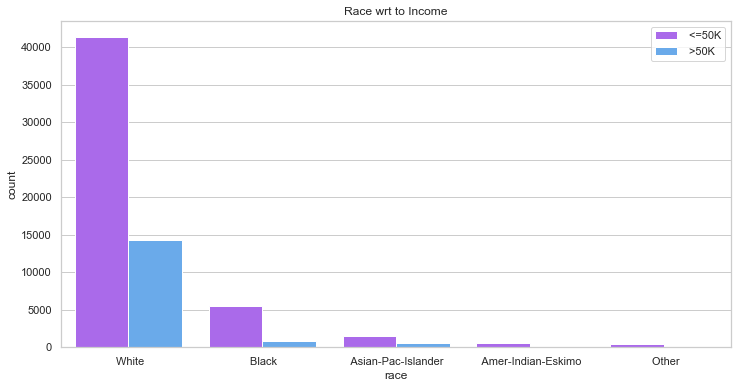

In [30]:
plt.figure(figsize=(12,6))
ax=sns.countplot(x='race',hue='income',data=df,palette='cool_r')
ax.set_title('Race wrt to Income')
ax.legend()

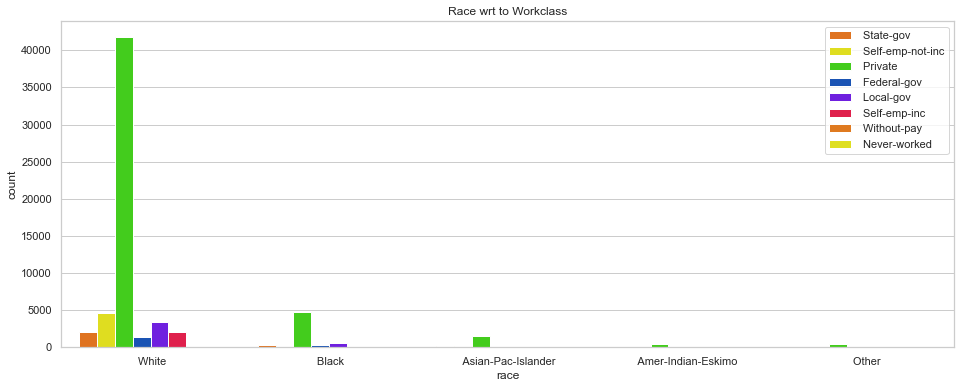

In [31]:
plt.figure(figsize=(16,6))
ax=sns.countplot(x='race',hue='workclass',data=df,palette='prism')
ax.set_title('Race wrt to Workclass')
ax.legend(loc='upper right')

#### native country

In [32]:
df['native_country'].value_counts()

 United-States                 59506
 Mexico                         1286
 Philippines                     396
 Germany                         274
 Canada                          242
 Puerto-Rico                     228
 El-Salvador                     212
 India                           200
 Cuba                            190
 England                         180
 Jamaica                         162
 South                           160
 China                           150
 Italy                           146
 Dominican-Republic              140
 Vietnam                         134
 Guatemala                       128
 Japan                           124
 Poland                          120
 Columbia                        118
 Taiwan                          102
 Haiti                            88
 Iran                             86
 Portugal                         74
 Nicaragua                        68
 Peru                             62
 France                           58
 

#### the data we have is more domianted with 'UnitedStates'

## Numerical Columns

In [33]:
num_columns

['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week']

#### age

In [34]:
df['age'].unique()

array([39, 50, 38, 53, 28, 37, 49, 52, 31, 42, 30, 23, 32, 40, 34, 25, 43,
       54, 35, 59, 56, 19, 20, 45, 22, 48, 21, 24, 57, 44, 41, 29, 18, 47,
       46, 36, 79, 27, 67, 33, 76, 17, 55, 61, 70, 64, 71, 68, 66, 51, 58,
       26, 60, 90, 75, 65, 77, 62, 63, 80, 72, 74, 69, 73, 81, 78, 88, 82,
       83, 84, 85, 86, 87], dtype=int64)

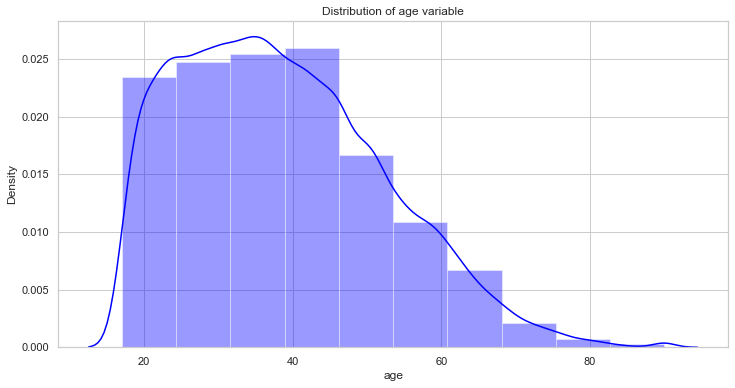

In [35]:
plt.figure(figsize=(12,6))
ax = sns.distplot(df['age'], bins=10, color='blue')
ax.set_title("Distribution of age variable")
plt.show()

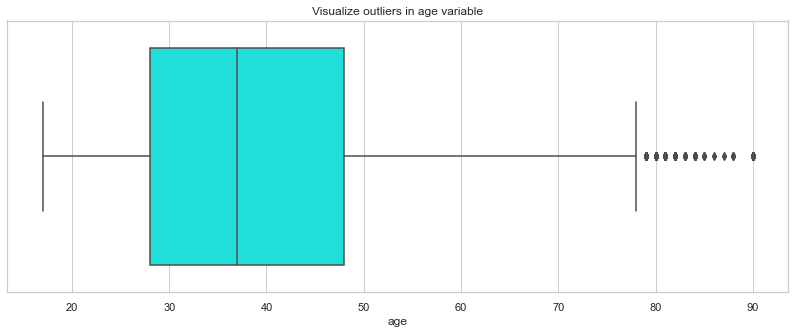

In [36]:
plt.figure(figsize=(14,5))
ax = sns.boxplot(df['age'],palette='hsv')
ax.set_title("Visualize outliers in age variable")
plt.show()

###### we can find outliers in the age data

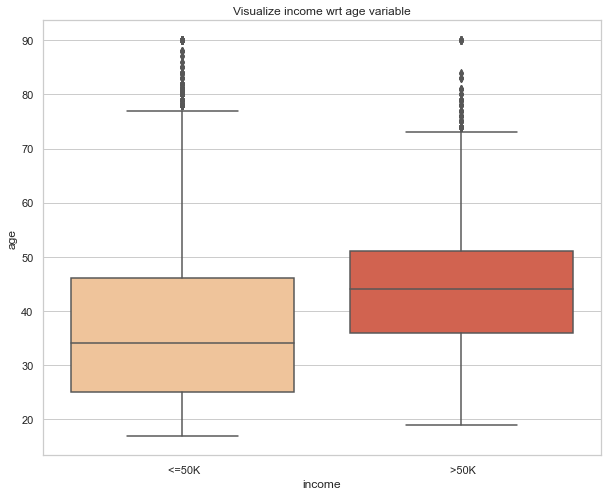

In [37]:
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.boxplot(x="income", y="age", data=df,palette='OrRd')
ax.set_title("Visualize income wrt age variable")
plt.show()

###### as the age increases, salary also increases

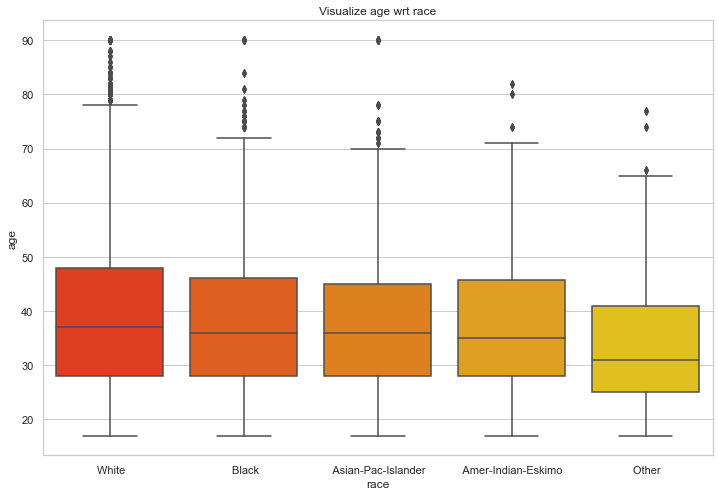

In [38]:
plt.figure(figsize=(12,8))
sns.boxplot(x ='race', y="age", data = df,palette='autumn')
plt.title("Visualize age wrt race")
plt.show()

###### whites are elder than others

###### hours_per_weak

In [39]:
df['hours_per_week'].describe()

count    65122.000000
mean        40.437456
std         12.347334
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours_per_week, dtype: float64

##### average working hours per week are 40hours

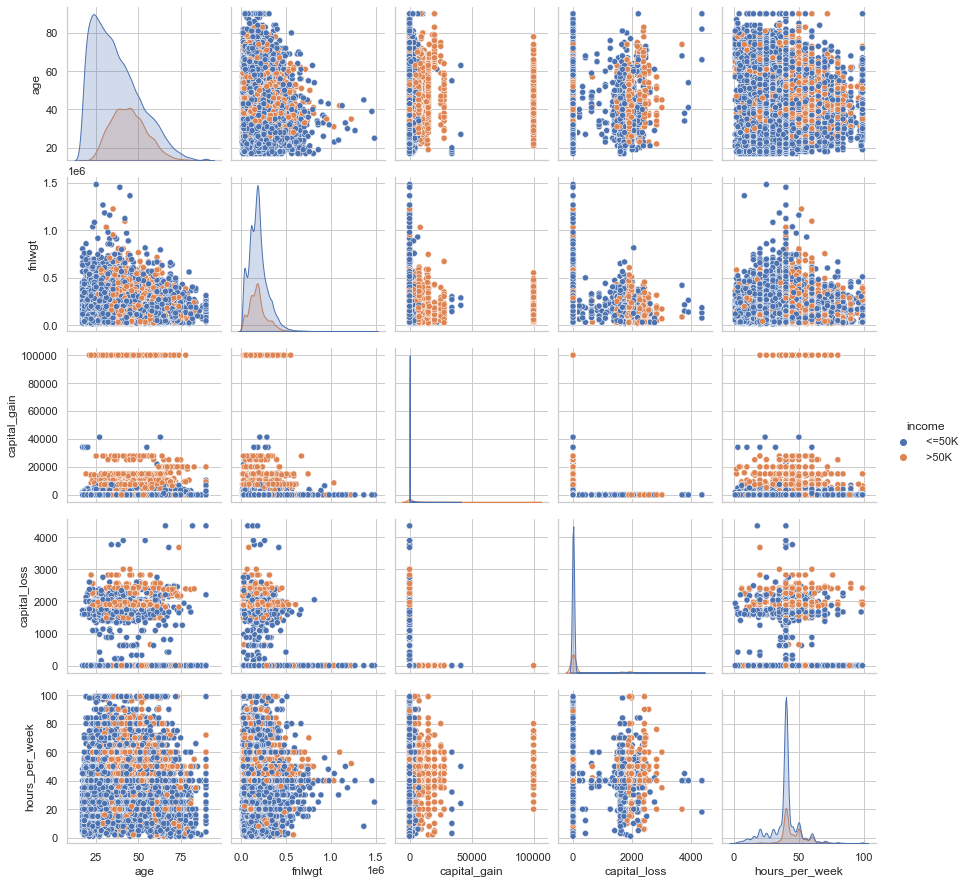

In [40]:
sns.pairplot(df, hue="income")
plt.show()

###### age and fnlwgt are positively skewed
###### education_num, hours_per_week are normaly distributed

In [41]:
def feature_engineering(df):
    
    #workclass
    workClass={value:key for key,value in enumerate(df['workclass'].unique())}
    df['workclass']=df['workclass'].map(workClass)
    
    #education
    eduCation={value:key for key,value in enumerate(df['education'].unique())}
    df['education']=df['education'].map(eduCation)
    
    #marital_status
    maritalStatus={value:key for key,value in enumerate(df['marital_status'].unique())}
    df['marital_status']=df['marital_status'].map(maritalStatus)
    
    #occupation
    occuPation={value:key for key,value in enumerate(df['occupation'].unique())}
    df['occupation']=df['occupation'].map(occuPation)
    
    #relationship
    relationShip={value:key for key,value in enumerate(df['relationship'].unique())}
    df['relationship']=df['relationship'].map(relationShip)
    
    #race
    Race={value:key for key,value in enumerate(df['race'].unique())}
    df['race']=df['race'].map(Race)
    
    #sex
    Sex={value:key for key,value in enumerate(df['sex'].unique())}
    df['sex']=df['sex'].map(Sex)
    
    #native_country
    nativeCountry={value:key for key,value in enumerate(df['native_country'].unique())}
    df['native_country']=df['native_country'].map(nativeCountry)
    
    return df

In [42]:
df=feature_engineering(df)

In [43]:
df.head()

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,0,77516,0,0,0,0,0,0,2174,0,40,0,<=50K
1,50,1,83311,0,1,1,1,0,0,0,0,13,0,<=50K
2,38,2,215646,1,2,2,0,0,0,0,0,40,0,<=50K
3,53,2,234721,2,1,2,1,1,0,0,0,40,0,<=50K
4,28,2,338409,0,1,3,2,1,1,0,0,40,1,<=50K


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65122 entries, 0 to 65121
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             65122 non-null  int64 
 1   workclass       65122 non-null  int64 
 2   fnlwgt          65122 non-null  int64 
 3   education       65122 non-null  int64 
 4   marital_status  65122 non-null  int64 
 5   occupation      65122 non-null  int64 
 6   relationship    65122 non-null  int64 
 7   race            65122 non-null  int64 
 8   sex             65122 non-null  int64 
 9   capital_gain    65122 non-null  int64 
 10  capital_loss    65122 non-null  int64 
 11  hours_per_week  65122 non-null  int64 
 12  native_country  65122 non-null  int64 
 13  income          65122 non-null  object
dtypes: int64(13), object(1)
memory usage: 7.0+ MB


# Independent and Dependent Feature

In [45]:
X=df.iloc[:,:-1]

In [46]:
X.head()

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,39,0,77516,0,0,0,0,0,0,2174,0,40,0
1,50,1,83311,0,1,1,1,0,0,0,0,13,0
2,38,2,215646,1,2,2,0,0,0,0,0,40,0
3,53,2,234721,2,1,2,1,1,0,0,0,40,0
4,28,2,338409,0,1,3,2,1,1,0,0,40,1


In [47]:
y=df['income']

In [48]:
y.value_counts()

 <=50K    49440
 >50K     15682
Name: income, dtype: int64

# Splitting Data

In [49]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [50]:
X_train.shape,X_test.shape

((45585, 13), (19537, 13))

## Model Building

In [51]:
from xgboost import XGBClassifier

xgb=XGBClassifier()

In [52]:
y_pred = xgb.fit(X_train, y_train).predict(X_test)

[15:08:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [53]:
from sklearn.metrics import accuracy_score

In [54]:
ac=accuracy_score(y_test,y_pred)
ac

0.889440548702462

In [55]:
!pip install lightgbm
!pip install catboost
!pip install xgboost

# Decision Tree

In [56]:
from sklearn.tree import DecisionTreeClassifier
treeClassifier = DecisionTreeClassifier(max_depth=3, min_samples_leaf=6)
treeClassifier.fit(X_train,y_train)
#prediction 
y_pred = treeClassifier.predict(X_test)
#print(y_pred)
#Check classification report with confusion matrix and report
from sklearn.metrics import classification_report,confusion_matrix
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

       <=50K       0.80      1.00      0.89     14878
        >50K       0.99      0.20      0.34      4659

    accuracy                           0.81     19537
   macro avg       0.89      0.60      0.61     19537
weighted avg       0.84      0.81      0.76     19537



# Random forest

In [57]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=40)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
cr = classification_report(y_test,rfc_pred)
print(cr)

              precision    recall  f1-score   support

       <=50K       0.96      0.98      0.97     14878
        >50K       0.94      0.88      0.91      4659

    accuracy                           0.96     19537
   macro avg       0.95      0.93      0.94     19537
weighted avg       0.96      0.96      0.96     19537



# Logistic Regression¶

In [58]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_logistic_pred = model.predict(X_test)
logistic_re = classification_report(y_test,y_logistic_pred)
print(logistic_re)

              precision    recall  f1-score   support

       <=50K       0.81      0.97      0.88     14878
        >50K       0.73      0.28      0.40      4659

    accuracy                           0.80     19537
   macro avg       0.77      0.62      0.64     19537
weighted avg       0.79      0.80      0.77     19537



# KNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

In [60]:
for i,k in enumerate(neighbors):
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit the model
    knn.fit(X_train, y_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    # Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 

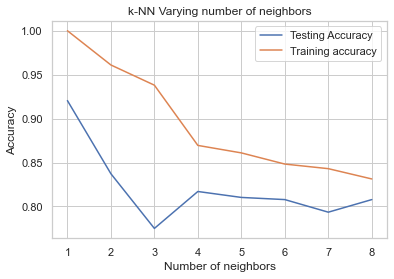

In [61]:
# Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [62]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.8170138711163434

# SVM

In [63]:
from sklearn.svm import SVC # support vector classifier
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[14844    34]
 [ 3823   836]]
              precision    recall  f1-score   support

       <=50K       0.80      1.00      0.89     14878
        >50K       0.96      0.18      0.30      4659

    accuracy                           0.80     19537
   macro avg       0.88      0.59      0.59     19537
weighted avg       0.83      0.80      0.75     19537



In [64]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN,AgglomerativeClustering


In [65]:
kmeans=KMeans(n_clusters = 2,init = 'k-means++',max_iter = 300, n_init = 10,random_state = 0)             


In [66]:
kmeans.fit(X_train)

KMeans(n_clusters=2, random_state=0)

In [67]:
kmeans.cluster_centers_

array([[3.69145270e+01, 2.09721284e+00, 3.26369531e+05, 3.60447635e+00,
        1.02280405e+00, 4.26984797e+00, 1.55059122e+00, 2.36908784e-01,
        3.01604730e-01, 1.03015785e+03, 8.44422297e+01, 4.03476351e+01,
        1.30658784e+00],
       [3.91449400e+01, 2.10688991e+00, 1.41943397e+05, 3.36387613e+00,
        1.09859238e+00, 4.15783079e+00, 1.53922063e+00, 2.18313824e-01,
        3.40139280e-01, 1.06007675e+03, 9.07161950e+01, 4.04483331e+01,
        1.08881316e+00]])

In [68]:
labels = pairwise_distances_argmin(X_train, kmeans.cluster_centers_)
metrics = {"Model":kmeans, "Silhouette Score":silhouette_score(X_train,labels)}
print(f"Model: {kmeans}")
print(f"\nSilhouette coefficient: {silhouette_score(X_train,labels):0.2f}")
print(f"\n\nInertia:{kmeans.inertia_}")
print(f"\n\nLabels : {labels}")

Model: KMeans(n_clusters=2, random_state=0)

Silhouette coefficient: 0.59


Inertia:210156426217250.78


Labels : [1 1 1 ... 1 1 1]


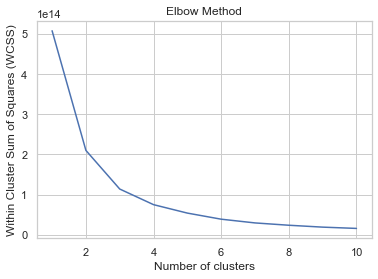

In [69]:
wcss=[]
for i in range(1, 11):
    model = KMeans(n_clusters = i,init = 'k-means++', max_iter = 300,n_init = 10, 
                    random_state = 0)          
    model.fit(X_train)                              
    wcss.append(model.inertia_)

# Show Elbow plot
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')                               # Set plot title
plt.xlabel('Number of clusters')                        # Set x axis name
plt.ylabel('Within Cluster Sum of Squares (WCSS)')      # Set y axis name
plt.show()


In [70]:
!pip install kneed

In [72]:
def apply_clustering(algorithm=None,n_clusters=3,data=None,scale=None, feat_selection=None):
    # Applying Model
    if algorithm in [KMeans, MiniBatchKMeans]:
        if algorithm == KMeans:
            model = algorithm(n_clusters=n_clusters)
            model.fit(data)
            cluster_centers = np.sort(model.cluster_centers_, axis = 0)
            labels = pairwise_distances_argmin(data, cluster_centers)
            metrics = {"Model": model, "Silhouette Score":silhouette_score(data,labels)}
        elif algorithm == MiniBatchKMeans:
            model = MiniBatchKMeans(init ='k-means++', n_clusters=n_clusters, batch_size=2, n_init=10, max_no_improvement=10, verbose=0)
            model.fit(data)
            labels = pairwise_distances_argmin(data, model.cluster_centers_)
            metrics = {"Model": model, "Silhouette Score":silhouette_score(data,labels)}
        print(f"Model: {model}")
        print(f"\nSilhouette coefficient: {silhouette_score(data,labels):0.2f}")
        print(f"\n\nInertia:{model.inertia_}")
        print(f"\n\nLabels : {labels}")
        return metrics
    elif algorithm in [DBSCAN, AgglomerativeClustering]:
        if algorithm == DBSCAN:
            model = algorithm(eps = 0.0375, n_clusters = 3)
            model.fit(data)
            metrics = {"Model": str(algorithm()), "Silhouette Score":silhouette_score(data, model.labels_)}
        elif algorithm == AgglomerativeClustering:
            model = algorithm(affinity='euclidean', linkage='ward')  
            model.fit_predict(data)
            metrics = {"Model": str(algorithm()), "Silhouette Score":silhouette_score(data, model.labels_)}
        print(f"Model: {model}")
        print(f"\nSilhouette coefficient: {silhouette_score(data, model.labels_)}")
        print(f"\nLabels: {model.labels_}")
        return metrics


In [73]:
apply_clustering(algorithm=MiniBatchKMeans, n_clusters=3, data=X_train, feat_selection=True)

Model: MiniBatchKMeans(batch_size=2, n_clusters=3, n_init=10)

Silhouette coefficient: 0.54


Inertia:140818763854278.06


Labels : [1 2 1 ... 1 2 1]


{'Model': MiniBatchKMeans(batch_size=2, n_clusters=3, n_init=10),
 'Silhouette Score': 0.5427810123228971}

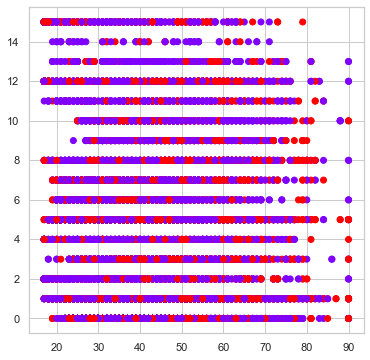

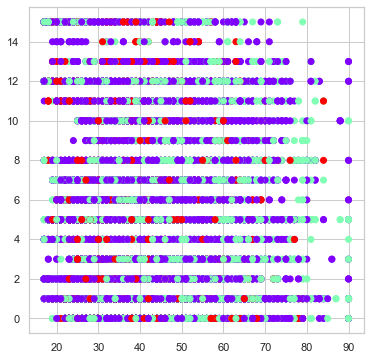

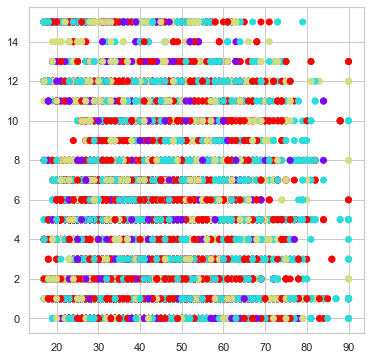

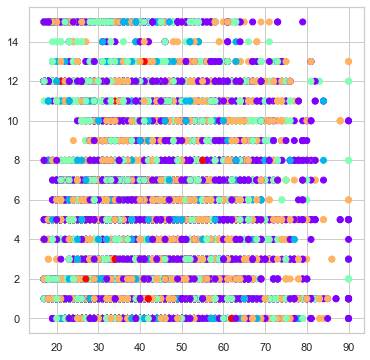

In [76]:
AgglomerativeClustering


k=[2,3,4,5]
for i in k:
    ac4 = AgglomerativeClustering(n_clusters=i )
    plt.figure(figsize =(6, 6))
    plt.scatter(X_train['age'],X_train['education'],
                c = ac4.fit_predict(X_train), cmap ='rainbow')
    plt.show()

In [77]:
apply_clustering(algorithm=AgglomerativeClustering, n_clusters=2, data=X_train, feat_selection=True)

Model: AgglomerativeClustering()

Silhouette coefficient: 0.46298215265257175

Labels: [0 1 0 ... 0 1 0]


{'Model': 'AgglomerativeClustering()', 'Silhouette Score': 0.46298215265257175}

----------------------------------------------------------------------------------------------------
Model: KMeans(n_clusters=2)

Silhouette coefficient: 0.59


Inertia:210156426217250.78


Labels : [0 0 0 ... 0 0 0]
----------------------------------------------------------------------------------------------------
Model: MiniBatchKMeans(batch_size=2, n_clusters=2, n_init=10)

Silhouette coefficient: 0.60


Inertia:231122549647097.62


Labels : [0 0 0 ... 0 0 0]
----------------------------------------------------------------------------------------------------
Model: AgglomerativeClustering()

Silhouette coefficient: 0.46298215265257175

Labels: [0 1 0 ... 0 1 0]
                                               Model  Silhouette Score
0                               KMeans(n_clusters=2)          0.585088
1  MiniBatchKMeans(batch_size=2, n_clusters=2, n_...          0.600216
2                          AgglomerativeClustering()          0.462982


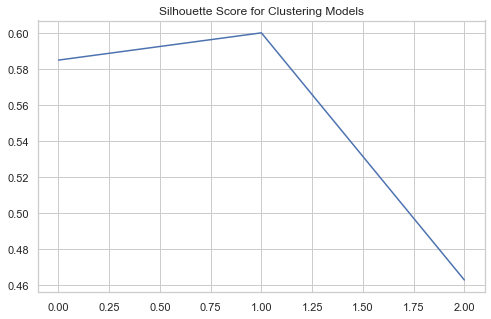

In [78]:
models = [KMeans, MiniBatchKMeans, AgglomerativeClustering]
metrics_df = pd.DataFrame()
for m in models: 
    print("--"*50)
    metrics = apply_clustering(algorithm=m, n_clusters=2, data=X_train, feat_selection=True)
    metrics_df = metrics_df.append(metrics, ignore_index=True)  
print(metrics_df)
# Silhouette Score Plot
metrics_df['Silhouette Score'].plot(figsize=(8,5))
plt.title('Silhouette Score for Clustering Models')
plt.show()